## Assignment 5 

### To build a time sequence model for predicting short term future stock prices from historical data.

## **Objective**
To build a time sequence model for predicting short term future stock prices from historical data.
 
## **Data**
Historical stock price data on US-based stocks, last updated in 2017. The dataset is available at Huge Stock Market Dataset | Kaggle and is provided by Boris Marjanovic. A list of stock ticker symbols is available at List of All Stock Ticker Symbols - Stock Analysis, to help identify the name of the stock from the txt file name.
 
## **Problem Statement**
An investment company is interested in learning about the potential profit in frequent buy/sell stock transactions. You are tasked with developing a time sequence model to predict the price two days ahead based on recent prices. Choose four (or more) of the data files for training and a separate two for validation. Once the model is finalized, demonstrate how well your model makes predictions by using two other data files for testing.

In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, SimpleRNN
from tensorflow.keras.layers import SimpleRNN, Activation, Dropout, Dense, Reshape, MaxPooling1D
%matplotlib inline 


In [2]:
file_path = r'D:\Stocks\Stocks'

def load_txt_data(file_path):
   
    df = pd.read_csv(file_path, delimiter=',', parse_dates=['Date'])
    df.sort_values(by='Date', inplace=True)
    return df

data_path = file_path
example_file = os.path.join(data_path, 'a.us.txt')  
stock_data = load_txt_data(example_file)
print(stock_data.head())  




        Date    Open    High     Low   Close    Volume  OpenInt
0 1999-11-18  30.713  33.754  27.002  29.702  66277506        0
1 1999-11-19  28.986  29.027  26.872  27.257  16142920        0
2 1999-11-22  27.886  29.702  27.044  29.702   6970266        0
3 1999-11-23  28.688  29.446  27.002  27.002   6332082        0
4 1999-11-24  27.083  28.309  27.002  27.717   5132147        0


C:\Users\Manju\anaconda3\envs\NN\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


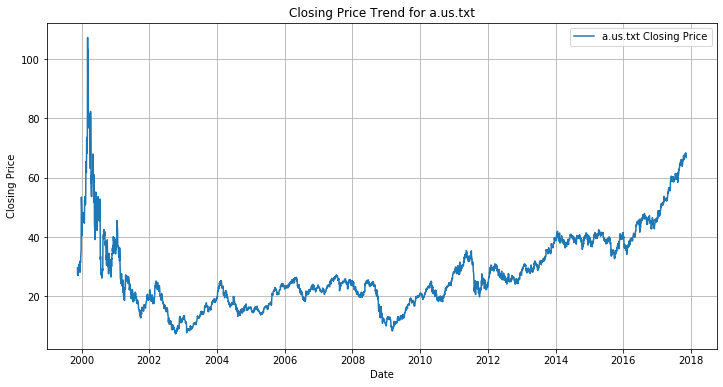

In [3]:
def plot_data(df, stock_name):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], label=f'{stock_name} Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'Closing Price Trend for {stock_name}')
    plt.legend()
    plt.grid()
    plt.show()

plot_data(stock_data, 'a.us.txt')


In [4]:
# def load_txt_data(file_path):
   
#     df = pd.read_csv(file_path, delimiter=',', parse_dates=['Date'])
#     df.sort_values(by='Date', inplace=True) 
#     return df


In [5]:
with open(r'D:\Stocks\Stocks\a.us.txt', 'r') as file:  
    for i in range(5):
        print(file.readline())


Date,Open,High,Low,Close,Volume,OpenInt

1999-11-18,30.713,33.754,27.002,29.702,66277506,0

1999-11-19,28.986,29.027,26.872,27.257,16142920,0

1999-11-22,27.886,29.702,27.044,29.702,6970266,0

1999-11-23,28.688,29.446,27.002,27.002,6332082,0



In [6]:
updated_path = r'D:\Stocks\Stocks'

In [7]:
def load_data_from_folder(folder_path):
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]  
    data = {}
    
    for file in all_files:
        stock_name = file.split('.')[0]  
        file_path = os.path.join(folder_path, file)  
        
        try:
            stock_data = load_txt_data(file_path)  
            if stock_data is not None and not stock_data.empty: 
                data[stock_name] = stock_data
            else:
                print(f"Warning: File {file} is empty or has no valid data. Skipping.")
        except Exception as e:
            print(f"Error loading file {file}: {e}. Skipping.")
    
    return data




In [8]:

def plot_data(df, stock_name):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], label=f'{stock_name} Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'Closing Price Trend for {stock_name}')
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
# Load all files in the folder
stock_data_dict = load_data_from_folder(updated_path)



Error loading file accp.us.txt: No columns to parse from file. Skipping.
Error loading file amrh.us.txt: No columns to parse from file. Skipping.
Error loading file amrhw.us.txt: No columns to parse from file. Skipping.
Error loading file asns.us.txt: No columns to parse from file. Skipping.
Error loading file bbrx.us.txt: No columns to parse from file. Skipping.
Error loading file bolt.us.txt: No columns to parse from file. Skipping.
Error loading file boxl.us.txt: No columns to parse from file. Skipping.
Error loading file bxg.us.txt: No columns to parse from file. Skipping.
Error loading file ehr.us.txt: No columns to parse from file. Skipping.
Error loading file fmax.us.txt: No columns to parse from file. Skipping.
Error loading file gnst.us.txt: No columns to parse from file. Skipping.
Error loading file hayu.us.txt: No columns to parse from file. Skipping.
Error loading file jt.us.txt: No columns to parse from file. Skipping.
Error loading file mapi.us.txt: No columns to parse fr

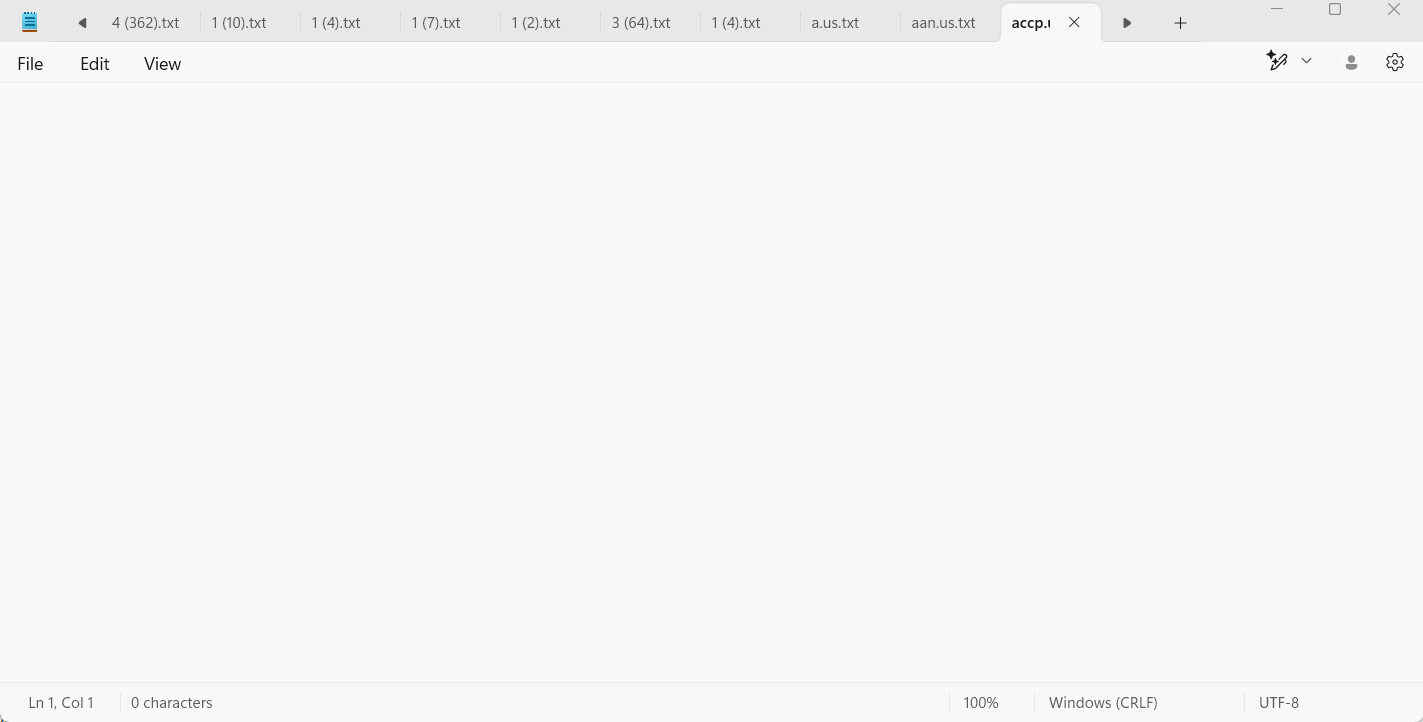

Some of the files as shown above were empty, so we did not load them into the model.

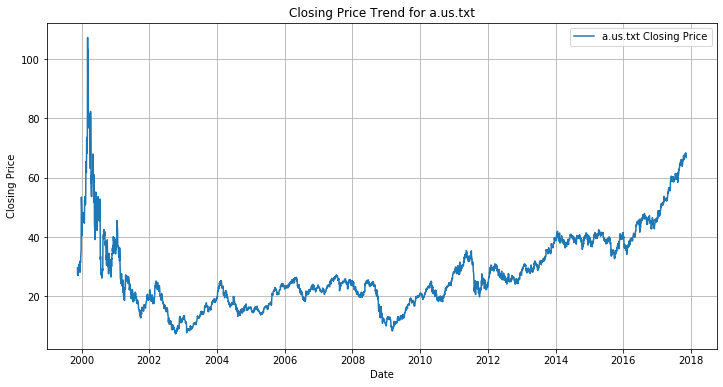

In [10]:
plot_data(stock_data_dict['a'], 'a.us.txt')

In [11]:
def create_input_label_arrays(df, lookback=5):
    data = df['Close'].values
    inputs, labels = [], []
    for i in range(len(data) - lookback - 2):  # Predicting 2 days into the future
        inputs.append(data[i:i + lookback])
        labels.append(data[i + lookback + 2])
    return np.array(inputs), np.array(labels)

# Preparing inputs and labels
inputs, labels = create_input_label_arrays(stock_data_dict['a'], lookback=5)


In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
inputs_scaled = scaler.fit_transform(inputs)
# normalizing data


## Modelling

In [13]:
# Reshaping data for Conv1D input
inputs_scaled = inputs_scaled.reshape((inputs_scaled.shape[0], inputs_scaled.shape[1]))

# Splitting data
split_ratio = [0.7, 0.15, 0.15]  
train_size = int(len(inputs_scaled) * split_ratio[0])
val_size = int(len(inputs_scaled) * split_ratio[1])

x_train, y_train = inputs_scaled[:train_size], labels[:train_size]
x_val, y_val = inputs_scaled[train_size:train_size + val_size], labels[train_size:train_size + val_size]
x_test, y_test = inputs_scaled[train_size + val_size:], labels[train_size + val_size:]


In [14]:
#Shape of x_train
x_train.shape

(3159, 5)

In [15]:
#Building model
look_back=5
model_0 = Sequential()
model_0.add(Reshape((look_back,1), input_shape = (look_back,)))
model_0.add(Conv1D(32, 3, activation='relu'))
model_0.add(SimpleRNN(50))
model_0.add(Dropout(0.25))
model_0.add(Dense(1))
model_0.add(Activation('linear'))

In [16]:
model_0.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 5, 1)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3, 32)             128       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 50)                4150      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 4,329
Trainable params: 4,329
Non-trainable params: 0
______________________________________________________

In [18]:
#Train the model on the training data without using a validation split
model_0.fit(x_train, y_train, epochs=100, batch_size=32, verbose=2)

Train on 3159 samples
Epoch 1/100
3159/3159 - 3s - loss: 362.2952
Epoch 2/100
3159/3159 - 1s - loss: 163.2695
Epoch 3/100
3159/3159 - 1s - loss: 125.5041
Epoch 4/100
3159/3159 - 1s - loss: 111.3941
Epoch 5/100
3159/3159 - 1s - loss: 102.4738
Epoch 6/100
3159/3159 - 1s - loss: 75.3070
Epoch 7/100
3159/3159 - 1s - loss: 63.5556
Epoch 8/100
3159/3159 - 1s - loss: 56.7076
Epoch 9/100
3159/3159 - 1s - loss: 49.4877
Epoch 10/100
3159/3159 - 1s - loss: 46.2514
Epoch 11/100
3159/3159 - 1s - loss: 42.0727
Epoch 12/100
3159/3159 - 1s - loss: 38.1216
Epoch 13/100
3159/3159 - 1s - loss: 36.9209
Epoch 14/100
3159/3159 - 1s - loss: 34.3592
Epoch 15/100
3159/3159 - 1s - loss: 31.8937
Epoch 16/100
3159/3159 - 1s - loss: 29.3189
Epoch 17/100
3159/3159 - 1s - loss: 26.5365
Epoch 18/100
3159/3159 - 1s - loss: 26.3254
Epoch 19/100
3159/3159 - 1s - loss: 24.9967
Epoch 20/100
3159/3159 - 1s - loss: 22.9296
Epoch 21/100
3159/3159 - 1s - loss: 22.5414
Epoch 22/100
3159/3159 - 1s - loss: 21.8233
Epoch 23/100
3

In [19]:
#Calculate training loss
score_train = model_0.evaluate(x_train, y_train, verbose=0)
print('Train RMSE: %.2f RMSE' % (math.sqrt(score_train)))

Train RMSE: 2.13 RMSE


Vaildation RMSE: 0.92 RMSE


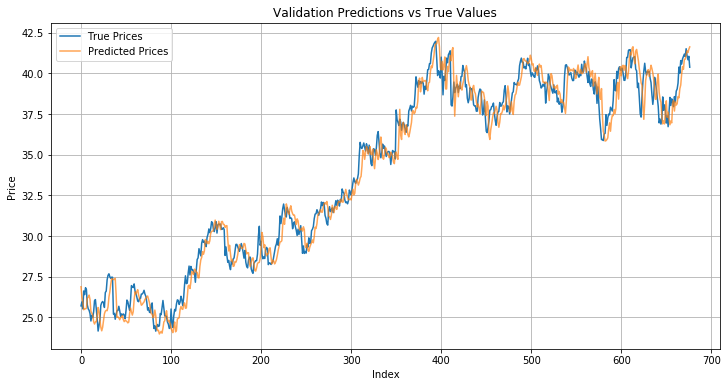

In [20]:
#make predictions on the validation data
y_val_pred = model_0.predict(x_val)

#Calculate validation loss
score_valid = model_0.evaluate(x_val, y_val, verbose=0)
print('Vaildation RMSE: %.2f RMSE' % (math.sqrt(score_valid)))


#Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='True Prices')
plt.plot(y_val_pred, label='Predicted Prices', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Validation Predictions vs True Values')
plt.legend()
plt.grid()
plt.show()


### model 1

In [21]:
look_back = 5
model_1 = Sequential()
model_1.add(Reshape((look_back,1), input_shape = (look_back,)))
model_1.add(Conv1D(128, 3, activation='relu'))
model_1.add(Conv1D(68, 3, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(SimpleRNN(100))
model_1.add(Dense(100))
model_1.add(Dense(1))
model_1.add(Activation('linear'))

In [22]:
model_1.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 5, 1)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 128)            512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 68)             26180     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 68)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               16900     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [24]:
#Train the model on the training data without using a validation split
model_1.fit(x_train, y_train, epochs=100, batch_size=32, verbose=2)

Train on 3159 samples
Epoch 1/100
3159/3159 - 2s - loss: 160.9971
Epoch 2/100
3159/3159 - 1s - loss: 10.8025
Epoch 3/100
3159/3159 - 1s - loss: 8.6924
Epoch 4/100
3159/3159 - 1s - loss: 7.5334
Epoch 5/100
3159/3159 - 1s - loss: 7.2819
Epoch 6/100
3159/3159 - 1s - loss: 6.9708
Epoch 7/100
3159/3159 - 1s - loss: 6.8884
Epoch 8/100
3159/3159 - 1s - loss: 7.2561
Epoch 9/100
3159/3159 - 1s - loss: 6.7800
Epoch 10/100
3159/3159 - 1s - loss: 6.5759
Epoch 11/100
3159/3159 - 1s - loss: 6.3940
Epoch 12/100
3159/3159 - 1s - loss: 6.3656
Epoch 13/100
3159/3159 - 1s - loss: 5.4112
Epoch 14/100
3159/3159 - 1s - loss: 6.2677
Epoch 15/100
3159/3159 - 1s - loss: 6.4131
Epoch 16/100
3159/3159 - 1s - loss: 5.7690
Epoch 17/100
3159/3159 - 1s - loss: 6.1231
Epoch 18/100
3159/3159 - 1s - loss: 6.2223
Epoch 19/100
3159/3159 - 1s - loss: 5.6860
Epoch 20/100
3159/3159 - 1s - loss: 5.6489
Epoch 21/100
3159/3159 - 1s - loss: 6.0306
Epoch 22/100
3159/3159 - 1s - loss: 5.4065
Epoch 23/100
3159/3159 - 1s - loss: 6.

In [25]:
#Calculate training loss
score_train = model_1.evaluate(x_train, y_train, verbose=0)
print('Train RMSE: %.2f RMSE' % (math.sqrt(score_train)))

Train RMSE: 2.03 RMSE


### Model 2

In [26]:


model_2 = Sequential()
model_2.add(Reshape((look_back,1), input_shape = (look_back,)))
model_2.add(Conv1D(32, 3, activation='relu'))
model_2.add(SimpleRNN(100))
model_2.add(Dropout(0.4))
model_2.add(Dense(1))
model_2.add(Activation('linear'))


model_2.compile(loss='mean_squared_error', optimizer='adam')

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 5, 1)              0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 32)             128       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100)               13300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 13,529
Trainable params: 13,529
Non-trainable params: 0
__________________________________________________

In [27]:
#Train the model on the training data without using a validation split
model_2.fit(x_train, y_train, epochs=100, batch_size=32, verbose=2)

Train on 3159 samples
Epoch 1/100
3159/3159 - 2s - loss: 259.0812
Epoch 2/100
3159/3159 - 1s - loss: 107.2398
Epoch 3/100
3159/3159 - 1s - loss: 72.7740
Epoch 4/100
3159/3159 - 1s - loss: 53.9436
Epoch 5/100
3159/3159 - 1s - loss: 45.1550
Epoch 6/100
3159/3159 - 1s - loss: 36.7701
Epoch 7/100
3159/3159 - 1s - loss: 32.3762
Epoch 8/100
3159/3159 - 1s - loss: 28.7315
Epoch 9/100
3159/3159 - 1s - loss: 25.1239
Epoch 10/100
3159/3159 - 1s - loss: 22.7956
Epoch 11/100
3159/3159 - 1s - loss: 20.6870
Epoch 12/100
3159/3159 - 1s - loss: 20.0063
Epoch 13/100
3159/3159 - 1s - loss: 18.2309
Epoch 14/100
3159/3159 - 1s - loss: 16.9572
Epoch 15/100
3159/3159 - 1s - loss: 15.9854
Epoch 16/100
3159/3159 - 1s - loss: 14.6288
Epoch 17/100
3159/3159 - 1s - loss: 14.4474
Epoch 18/100
3159/3159 - 1s - loss: 12.9546
Epoch 19/100
3159/3159 - 1s - loss: 14.3023
Epoch 20/100
3159/3159 - 1s - loss: 12.4668
Epoch 21/100
3159/3159 - 1s - loss: 13.6989
Epoch 22/100
3159/3159 - 1s - loss: 13.4294
Epoch 23/100
3159

In [28]:
#Calculate training loss
score_train = model_2.evaluate(x_train, y_train, verbose=0)
print('Train RMSE: %.2f RMSE' % (math.sqrt(score_train)))


Train RMSE: 2.18 RMSE


### Model 3

In [29]:
model_3 = Sequential()
model_3.add(Reshape((look_back,1), input_shape = (look_back,)))
model_3.add(Conv1D(64, 3, activation='relu'))
model_3.add(Conv1D(64, 3, activation='relu'))
model_3.add(Dropout(0.1))
model_3.add(SimpleRNN(100))

model_3.add(Dense(units=25))
model_3.add(Dense(1))
model_3.add(Activation('linear'))


model_3.compile(loss='mean_squared_error', optimizer='adam')

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 5, 1)              0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 3, 64)             256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 64)             12352     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100)               16500     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [30]:
#Train the model on the training data without using a validation split
model_3.fit(x_train, y_train, epochs=100, batch_size=32, verbose=2)

Train on 3159 samples
Epoch 1/100
3159/3159 - 3s - loss: 185.3497
Epoch 2/100
3159/3159 - 1s - loss: 14.7096
Epoch 3/100
3159/3159 - 1s - loss: 9.2108
Epoch 4/100
3159/3159 - 1s - loss: 7.8265
Epoch 5/100
3159/3159 - 1s - loss: 7.4693
Epoch 6/100
3159/3159 - 1s - loss: 7.5506
Epoch 7/100
3159/3159 - 1s - loss: 7.3249
Epoch 8/100
3159/3159 - 1s - loss: 6.9549
Epoch 9/100
3159/3159 - 1s - loss: 6.2989
Epoch 10/100
3159/3159 - 1s - loss: 6.7611
Epoch 11/100
3159/3159 - 1s - loss: 6.2125
Epoch 12/100
3159/3159 - 1s - loss: 6.0419
Epoch 13/100
3159/3159 - 1s - loss: 6.1194
Epoch 14/100
3159/3159 - 1s - loss: 5.8565
Epoch 15/100
3159/3159 - 1s - loss: 5.7644
Epoch 16/100
3159/3159 - 1s - loss: 6.2840
Epoch 17/100
3159/3159 - 1s - loss: 5.9783
Epoch 18/100
3159/3159 - 1s - loss: 5.8502
Epoch 19/100
3159/3159 - 1s - loss: 6.1205
Epoch 20/100
3159/3159 - 1s - loss: 5.6821
Epoch 21/100
3159/3159 - 1s - loss: 5.8009
Epoch 22/100
3159/3159 - 1s - loss: 6.1630
Epoch 23/100
3159/3159 - 1s - loss: 5.

In [31]:
#Calculate training loss
score_train = model_3.evaluate(x_train, y_train, verbose=0)
print('Train RMSE: %.2f RMSE' % (math.sqrt(score_train)))


Train RMSE: 2.03 RMSE


training loss for model_0:
Train RMSE: 2.13 RMSE
validation loss
Vaildation RMSE: 0.92 RMSE


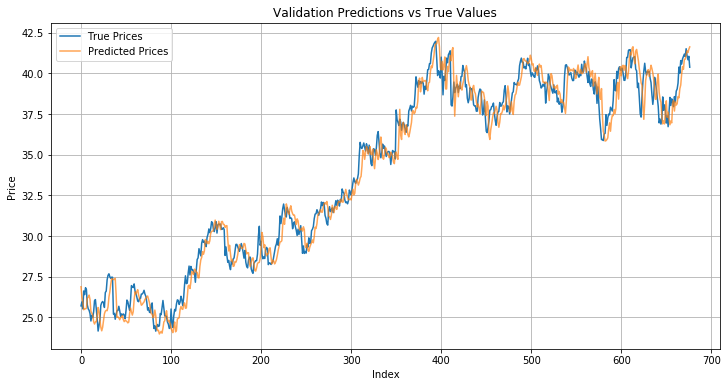

training loss for model_1:
Train RMSE: 2.03 RMSE
validation loss
Vaildation RMSE: 0.94 RMSE


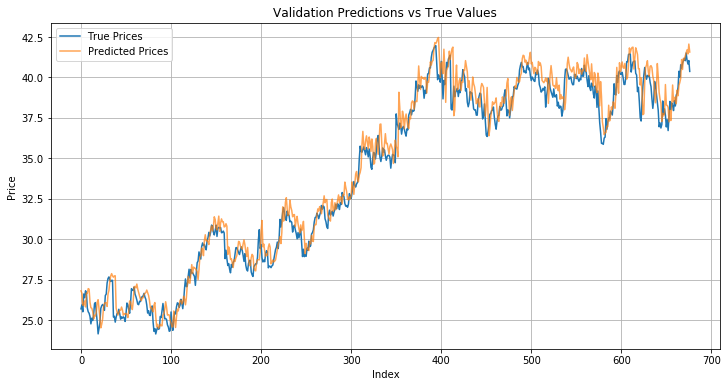

training loss for model_2:
Train RMSE: 2.18 RMSE
validation loss
Vaildation RMSE: 1.15 RMSE


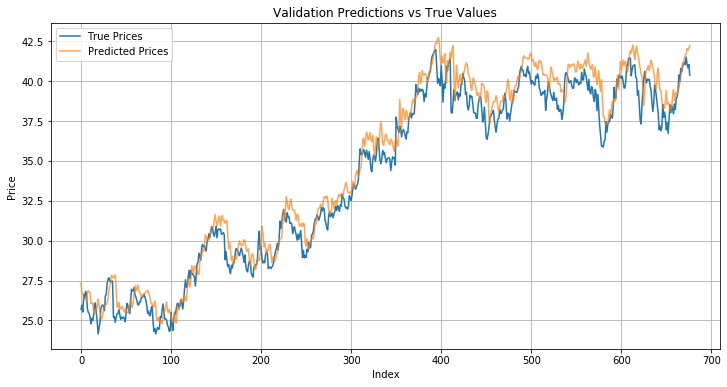

training loss for model_3:
Train RMSE: 2.03 RMSE
validation loss
Vaildation RMSE: 1.00 RMSE


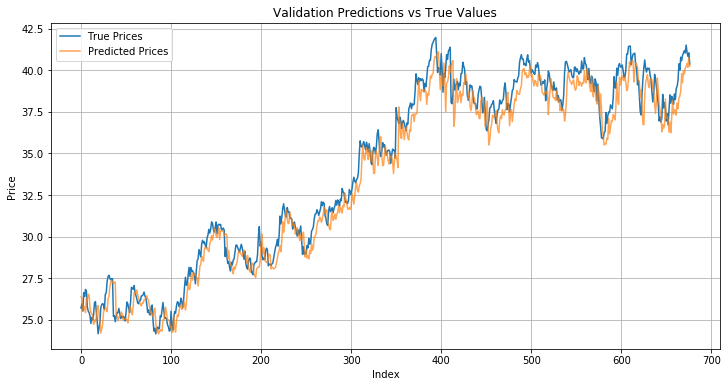

In [34]:
models = [model_0, model_1, model_2, model_3]
for index, model in enumerate(models):
    y_val_pred = model.predict(x_val)
    #Calculate training loss 
    print(f'training loss for model_{index}:')
    score_train = model.evaluate(x_train, y_train, verbose=0)
    print('Train RMSE: %.2f RMSE' % (math.sqrt(score_train)))
    
    #Calculate validation loss
    print('validation loss')
    score_valid = model.evaluate(x_val, y_val, verbose=0)
    print('Vaildation RMSE: %.2f RMSE' % (math.sqrt(score_valid)))
    
    
    #Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(y_val, label='True Prices')
    plt.plot(y_val_pred, label='Predicted Prices', alpha=0.7)
    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.title('Validation Predictions vs True Values')
    plt.legend()
    plt.grid()
    plt.show()

Best model is model_3.

Test RMSE: 1.49 RMSE


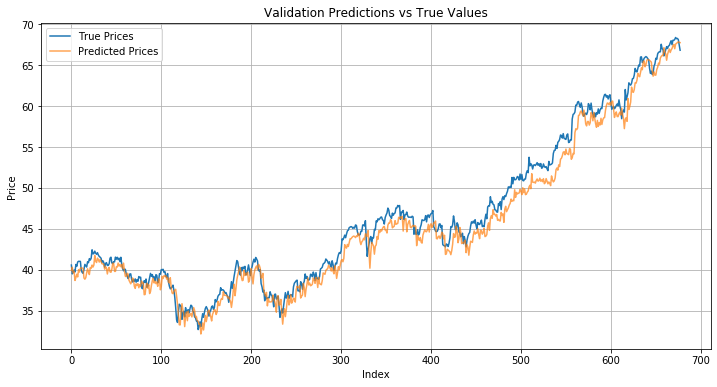

In [33]:
#Prediction on test data
test_pred = model_3.predict(x_test)


#Calculating testing loss
score_test = model_3.evaluate(x_test, y_test, verbose=0)
print('Test RMSE: %.2f RMSE' % (math.sqrt(score_test)))
    
#Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Prices')
plt.plot(test_pred, label='Predicted Prices', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Validation Predictions vs True Values')
plt.legend()
plt.grid()
plt.show()



In [46]:
#Predicitng value using model_3
# Reshape the test data to model's expected input shape
sample = x_test[115].reshape(1, -1)
# Prediction
test_pred = model_3.predict(sample)
# Compare predicted value with the actual label
actual_label = y_test[115]
print(f"Predicted Value: ${test_pred[0][0]}")
print(f"Actual Value: ${actual_label}")

Predicted Value: $37.50242614746094
Actual Value: $36.647


In [47]:
sample = x_test[300].reshape(1, -1)
# Predict
test_pred = model_3.predict(sample)
# Compare predicted value with the actual label
actual_label = y_test[300]
print(f"Predicted Value: ${test_pred[0][0]}")
print(f"Actual Value: ${actual_label}")

Predicted Value: $41.0980339050293
Actual Value: $42.313


## Discussion

- **Model_0** Train RMSE: 2.13 
- **Model_1** Train RMSE: 2.03
- **Model_2** Train RMSE: 2.18
- **Model_3** Train RMSE: 2.03

Model 3 achieved the lowest error compared to other models. This error indicates the average squared difference between the predicted and actual stock prices over the testing period.

Although we noticed some form of overfitting as the validation RMSEs are lower than that of the training.  

The model's performance suggests it is capable of reasonably predicting stock prices two days ahead, though occasional spikes in prediction error may occur during periods of high volatility.

Overall, Model 3 is the best performing model among the three tested.